In [1]:
'''!pip install matplotlib
!pip install seaborn
!pip install plotly.express

!pip install numpy
!pip install pandas
!pip install nbformat
!pip install sklearn
!pip install scikit-learn
!pip install scikit-plot'''

'!pip install matplotlib\n!pip install seaborn\n!pip install plotly.express\n\n!pip install numpy\n!pip install pandas\n!pip install nbformat\n!pip install sklearn\n!pip install scikit-learn\n!pip install scikit-plot'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

from scipy import stats

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
def inspect_values(df: pd.DataFrame) -> None:
    '''
    extensive overview of data
    '''
    for column in df.columns:
        print(f"column: {column}", end=' - ')
        if (df[column].dtype not in ['float64', 'int64', 'datetime64[ns]']) or (df[column].nunique() < 15):
            print(f"unique values: {df[column].unique()}", end=' - ')
        else:
            print(f"values: from {min(df[column])} to {max(df[column])}", end=' - ')
        print(f"datatype: {df[column].dtype}" , end=' - ')
        print('number of NaN values:', df[column].isna().sum())

In [5]:
clients = pd.read_csv('data/train/client_train.csv', low_memory=False, parse_dates=True)
invoices = pd.read_csv('data/train/invoice_train.csv', low_memory=False, parse_dates=True)

## loads of test data
# clients = pd.read_csv('data/test/client_test.csv', low_memory=False, parse_dates=True)
# invoices = pd.read_csv('data/test/invoice_test.csv', low_memory=False, parse_dates=True)

In [6]:
clients.describe()

disrict    client_catg         region         target
count  135493.000000  135493.000000  135493.000000  135493.000000
mean       63.511222      11.512506     206.159809       0.055841
std         3.354400       4.423761     104.207044       0.229614
min        60.000000      11.000000     101.000000       0.000000
25%        62.000000      11.000000     103.000000       0.000000
50%        62.000000      11.000000     107.000000       0.000000
75%        69.000000      11.000000     307.000000       0.000000
max        69.000000      51.000000     399.000000       1.000000

In [7]:
clients[clients['target'] == 1].shape[0] /clients.shape[0]

0.05584052312665599

In [8]:
## maybe we should not exclude it since test data include old invoices as well
# invoices = invoices[invoices['invoice_date'] > '2005-01-01']

In [9]:
## Baseline model

# A customer with exceptional fluctuations in monthly (or yearly??) consommation is likely to be a fraud. 
# If the clients STD is higher than the mean STD of all clients, they will be flagged as fraud. 
# OR: id STD is in top 5% of all clients 


baseline = invoices.copy()

baseline.eval('total_consommation = consommation_level_1 + consommation_level_2 + consommation_level_3 + consommation_level_4', inplace=True)
baseline.head()

base_grouped = baseline.groupby('client_id').total_consommation.std().reset_index()
base_grouped.head()

mean_std = base_grouped.total_consommation.mean()
mean_std

base_grouped['target_baseline'] = base_grouped.total_consommation > mean_std
base_grouped.head()

client_id  total_consommation  target_baseline
0     train_Client_0          341.553930            False
1     train_Client_1          197.935960            False
2    train_Client_10          646.808386             True
3   train_Client_100            3.607011            False
4  train_Client_1000          633.485669             True

574.2922421330854
Metric (AUC):  0.5775814701898836


<Axes: >

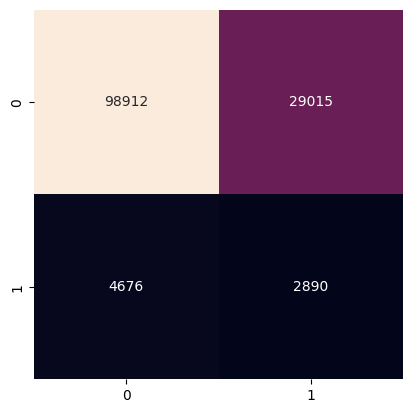

In [10]:
## how good is baseline model?

clients_baseline = pd.merge(left=clients, right=base_grouped.drop(columns='total_consommation', axis=1), on='client_id')

print(mean_std)
print('Metric (AUC): ', roc_auc_score(clients_baseline.target, clients_baseline.target_baseline))
sns.heatmap(confusion_matrix(clients_baseline.target, clients_baseline.target_baseline), square=True, annot=True, fmt='d', cbar=False)



In [11]:
clients_viz = pd.merge(left=clients, right=base_grouped, on='client_id')
px0 = clients_viz.groupby(['total_consommation', 'target']).size().to_frame('count').reset_index()
px0['target'] = px0['target'].map({0: 'legit', 1: 'fraud'})

fig = px.histogram(px0, x='total_consommation', range_x=[0, 2000], y='count', color='target', nbins=4000, text_auto=True, labels={'total_consommation': 'std of total consumption'}, template='plotly_dark', color_discrete_sequence=['#63ac47', '#f8e67c']).update_layout(yaxis_title="Count of customers")
fig.add_vline(x=mean_std, annotation_text='average std of all customers')

Milestone 1 (Vadym and Vanessa): \
Fraud Detection: \
Value of Product: \
Find fraudulent transactions, safe money, avoid reputation damage and prevent money laundering. \
Prediction: \
Detect anomalies in client's energy consummation behavior \
Evaluation Metric: \
AUC (recommended and given by Zindi) \
Baseline Model: \
A customer with exceptional fluctuations in monthly consummation is likely to be a fraud. \
If the clients' standard deviation of total consummation is higher than the average STD of all clients, they will be flagged as fraud. \
Score: \ 
AUC = 0.5776

In [12]:
inspect_values(clients)

column: disrict - unique values: [60 69 62 63] - datatype: int64 - number of NaN values: 0
column: client_id - unique values: ['train_Client_0' 'train_Client_1' 'train_Client_10' ...
 'train_Client_99997' 'train_Client_99998' 'train_Client_99999'] - datatype: object - number of NaN values: 0
column: client_catg - unique values: [11 12 51] - datatype: int64 - number of NaN values: 0
column: region - values: from 101 to 399 - datatype: int64 - number of NaN values: 0
column: creation_date - unique values: ['31/12/1994' '29/05/2002' '13/03/1986' ... '16/08/2004' '30/08/1978'
 '25/05/1978'] - datatype: object - number of NaN values: 0
column: target - unique values: [0. 1.] - datatype: float64 - number of NaN values: 0


In [13]:
inspect_values(invoices)

column: client_id - unique values: ['train_Client_0' 'train_Client_1' 'train_Client_10' ...
 'train_Client_99997' 'train_Client_99998' 'train_Client_99999'] - datatype: object - number of NaN values: 0
column: invoice_date - unique values: ['2014-03-24' '2013-03-29' '2015-03-23' ... '1995-11-28' '1982-07-04'
 '1996-09-02'] - datatype: object - number of NaN values: 0
column: tarif_type - values: from 8 to 45 - datatype: int64 - number of NaN values: 0
column: counter_number - values: from 0 to 27981145458733 - datatype: int64 - number of NaN values: 0
column: counter_statue - unique values: ['0' '1' '5' '4' '3' '2' '769' 'A' '618' '269375' '46' '420'] - datatype: object - number of NaN values: 0
column: counter_code - values: from 0 to 600 - datatype: int64 - number of NaN values: 0
column: reading_remarque - unique values: [  8   6   9   7 207 413 203   5] - datatype: int64 - number of NaN values: 0
column: counter_coefficient - values: from 0 to 50 - datatype: int64 - number of NaN v

In [14]:
# px.histogram(invoices[invoices['months_number'] < 12], x='months_number', histfunc='count')

In [15]:
invoices['total_consommation'] = invoices.eval("consommation_level_1 + consommation_level_2 + consommation_level_3 + consommation_level_4")

In [16]:
invoices_grouped = invoices.groupby('client_id').mean(numeric_only=True)
invoices_grouped.rename(mapper={'total_consommation': 'mean_total_consommation'}, axis=1, inplace=True)
invoices_grouped = invoices_grouped.reset_index()
agg_clients = pd.merge(left=clients, right=invoices_grouped[['client_id', 'mean_total_consommation']], how='left')


In [17]:
count_num = invoices.groupby('client_id').counter_number.nunique().to_frame('number_of_counter_numbers').reset_index()

agg_clients = pd.merge(left=agg_clients, right=count_num, on='client_id')

del count_num

In [18]:
counter_dict = {'A': 0, '0': 0, '1': 1, '5': 5, '4': 4, '3': 3, '2': 2, '769': 0, '618': 0, '269375': 0, '46': 0, '420': 0}
invoices.counter_statue = invoices.counter_statue.map(lambda x: counter_dict.get(x, x)).astype('int')

invoices.counter_statue.unique()

array([0, 1, 5, 4, 3, 2])

In [19]:
df = pd.merge(left=clients, right=invoices, on='client_id', how='left')

counter_statues = df.groupby('client_id').counter_statue.apply(stats.mode).apply(lambda x: x[0]).to_frame('mode_counter_statue').reset_index()
agg_clients = pd.merge(left=agg_clients, right=counter_statues, on='client_id')

del counter_statues

In [20]:
# df.groupby(['reading_remarque', 'target']).size()

In [21]:
remarque_dict = {5: 6, 207: 6, 413: 6, 203: 6}
invoices.reading_remarque = invoices.reading_remarque.map(lambda x: remarque_dict.get(x, x))

reading_mode = invoices.groupby('client_id').reading_remarque.apply(stats.mode).apply(lambda x: x[0]).to_frame('mode_reading_remarque').reset_index()
agg_clients = pd.merge(left=agg_clients, right=reading_mode, on='client_id')
del reading_mode

In [22]:
min_max = invoices.groupby('client_id').total_consommation.aggregate(['min', 'max'])
rng_total_consommation = min_max.apply(lambda x: x.to_list()[1] - x.to_list()[0], axis=1).to_frame('range_total_consommation').reset_index()

agg_clients = pd.merge(left=agg_clients, right=rng_total_consommation, on='client_id')
del min_max

In [23]:
invoices['invoice_date'] = pd.to_datetime(invoices['invoice_date'])

invoices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 17 columns):
 #   Column                Dtype         
---  ------                -----         
 0   client_id             object        
 1   invoice_date          datetime64[ns]
 2   tarif_type            int64         
 3   counter_number        int64         
 4   counter_statue        int64         
 5   counter_code          int64         
 6   reading_remarque      int64         
 7   counter_coefficient   int64         
 8   consommation_level_1  int64         
 9   consommation_level_2  int64         
 10  consommation_level_3  int64         
 11  consommation_level_4  int64         
 12  old_index             int64         
 13  new_index             int64         
 14  months_number         int64         
 15  counter_type          object        
 16  total_consommation    int64         
dtypes: datetime64[ns](1), int64(14), object(2)
memory usage: 580.6+ MB


In [24]:
# how long has customer been a customer? range between first and last date per client_id

minmax_date = invoices.groupby('client_id').invoice_date.aggregate(['min','max']).reset_index()

minmax_date['date_interval'] =((minmax_date['max'] - minmax_date['min']) / np.timedelta64(1, 'W')).astype('int')


agg_clients = pd.merge(left=agg_clients, right=minmax_date[['client_id', 'date_interval']], on='client_id')
del minmax_date

In [25]:
# does a client have only electricity, or gas too?

gaz_type = invoices.groupby('client_id').counter_type.aggregate(['max']).reset_index()

gaz_dict = {'ELEC': 0, 'GAZ':1}
gaz_type['has_gaz'] = gaz_type['max'].map(gaz_dict)

agg_clients = pd.merge(left=agg_clients, right=gaz_type.drop('max', axis=1), on='client_id')
del gaz_type


In [26]:
# TODO
# clean up
# rm or delete or del  unneeded dataframes

# new feature: is total consommation equal to difference in new_index and old_index?


In [27]:
std_consommation = invoices.groupby('client_id').total_consommation.std().reset_index()
std_consommation.rename(mapper={'total_consommation': 'std_total_consommation'}, axis=1, inplace=True)
agg_clients = pd.merge(left=agg_clients, right=std_consommation, on='client_id')
del std_consommation

In [28]:
# TODO: has both elec and gaz

In [29]:
## 

invoices['diff_index'] = invoices['new_index'] - invoices['old_index']
invoices['count_mismatch_per_invoice'] = invoices['total_consommation'] != invoices['diff_index']

count_mismatch = invoices.groupby('client_id')['count_mismatch_per_invoice'].sum().sort_values(ascending=False).reset_index()

agg_clients = pd.merge(left=agg_clients, right=count_mismatch, on='client_id')
del count_mismatch
#invoices.head()

In [30]:
#px.histogram(agg_clients[agg_clients.con_ind_mismatch > 0], x='con_ind_mismatch', histfunc='count', color='target')

In [31]:
#sns.scatterplot(data=agg_clients, x='target', y='con_ind_mismatch')

In [32]:
## before we looked at mismatches for individual invoices. now we look at total mismatch per client

invoices['diff_index'] = invoices['new_index'] - invoices['old_index']
invoices['con_ind_mismatch'] = invoices['total_consommation'] != invoices['diff_index']

count_mismatch = invoices.groupby('client_id')[['diff_index', 'total_consommation']].sum().sort_values('diff_index', ascending=False).reset_index()
count_mismatch['count_mismatch_energy'] = count_mismatch['total_consommation'] - count_mismatch['diff_index']
count_mismatch['count_mismatch_pooled'] = count_mismatch['count_mismatch_energy'] != 0 



#count_mismatch = pd.merge(left=count_mismatch, right=clients, on='client_id')
#count_mismatch.sample(10)

#count_mismatch.groupby(['test', 'target']).size()

agg_clients = pd.merge(left=agg_clients, right=count_mismatch[['client_id', 'count_mismatch_pooled']], on='client_id')
del count_mismatch

In [33]:
agg_clients.groupby(['target', 'has_gaz']).has_gaz.size()

target  has_gaz
0.0     0          70320
        1          57607
1.0     0           3119
        1           4447
Name: has_gaz, dtype: int64

In [34]:
# px.histogram(count_mismatch, x='count_mismatch_energy', histfunc='count', color='target', barmode='relative', nbins=10)

In [35]:
# clients[clients.target == 1].shape[0] / clients.shape[0]

In [36]:
px1 = agg_clients.groupby(['date_interval', 'target']).size().to_frame('count').reset_index()
px1['target'] = px1['target'].map({0: 'legit', 1: 'fraud'})

px.histogram(px1, x='date_interval', y='count', color='target', nbins=20, text_auto=True, labels={'date_interval': 'Weeks as a customer'}, template='plotly_dark', color_discrete_sequence=['#63ac47', '#f8e67c']).update_layout(yaxis_title="Count of customers")

In [37]:
px2 = agg_clients.groupby(['region', 'target']).size().to_frame('count').reset_index()
px2['target'] = px2['target'].map({0: 'legit', 1: 'fraud'})

fig = px.bar(px2, x='region', y='count', color='target', text_auto=True, labels={'date_interval': 'Weeks as a customer'}, template='plotly_dark', color_discrete_sequence=['#63ac47', '#f8e67c']).update_layout(yaxis_title="Count of customers")
fig.update_xaxes(type='category')

In [38]:
agg_clients.head()

disrict          client_id  client_catg  region creation_date  target  \
0       60     train_Client_0           11     101    31/12/1994     0.0   
1       69     train_Client_1           11     107    29/05/2002     0.0   
2       62    train_Client_10           11     301    13/03/1986     0.0   
3       69   train_Client_100           11     105    11/07/1996     0.0   
4       62  train_Client_1000           11     303    14/10/2014     0.0   

   mean_total_consommation  number_of_counter_numbers  mode_counter_statue  \
0               362.971429                          1                    0   
1               557.540541                          1                    0   
2               836.500000                          1                    0   
3                 1.200000                          1                    0   
4               922.642857                          1                    0   

   mode_reading_remarque  range_total_consommation  date_interval  has_gaz  \
0                      6                      1348            700        0   
1                      6                      1017            701        0   
2                      6                      2894            703        0   
3                      6                        15            380        0   
4                      9                      2258            226        0   

   std_total_consommation  count_mismatch_per_invoice  count_mismatch_pooled  
0              341.553930                           0                  False  
1              197.935960                           0                  False  
2              646.808386                           0                  False  
3                3.607011                           0                  False  
4              633.485669                           0                  False

## split data into features and target

In [39]:
X = agg_clients.drop(['target', 'client_id', 'creation_date'], axis=1)
y = agg_clients.target

## X for test data
# X = agg_clients.drop(['client_id', 'creation_date'], axis=1)


# fill NAs in std column
X.std_total_consommation = X.std_total_consommation.fillna(0)

In [40]:
# create dummies for categorical data

for col in X.columns:
    if X[col].nunique() < 30:
        dummie = pd.get_dummies(X[col], drop_first=True, prefix=col)
        
        X.drop(columns=col, inplace=True)
        X = X.join(dummie, how='left')

## dropped because features missing in test data
X = X.drop(['mode_counter_statue_2', 'region_199'], axis=1)
        
X.head()

mean_total_consommation  range_total_consommation  date_interval  \
0               362.971429                      1348            700   
1               557.540541                      1017            701   
2               836.500000                      2894            703   
3                 1.200000                        15            380   
4               922.642857                      2258            226   

   std_total_consommation  count_mismatch_per_invoice  disrict_62  disrict_63  \
0              341.553930                           0       False       False   
1              197.935960                           0       False       False   
2              646.808386                           0        True       False   
3                3.607011                           0       False       False   
4              633.485669                           0        True       False   

   disrict_69  client_catg_12  client_catg_51  region_103  region_104  \
0       False           False           False       False       False   
1        True           False           False       False       False   
2       False           False           False       False       False   
3        True           False           False       False       False   
4       False           False           False       False       False   

   region_105  region_106  region_107  region_206  region_301  region_302  \
0       False       False       False       False       False       False   
1       False       False        True       False       False       False   
2       False       False       False       False        True       False   
3        True       False       False       False       False       False   
4       False       False       False       False       False       False   

   region_303  region_304  region_305  region_306  region_307  region_308  \
0       False       False       False       False       False       False   
1       False       False       False       False       False       False   
2       False       False       False       False       False       False   
3       False       False       False       False       False       False   
4        True       False       False       False       False       False   

   region_309  region_310  region_311  region_312  region_313  region_371  \
0       False       False       False       False       False       False   
1       False       False       False       False       False       False   
2       False       False       False       False       False       False   
3       False       False       False       False       False       False   
4       False       False       False       False       False       False   

   region_372  region_379  region_399  number_of_counter_numbers_2  \
0       False       False       False                        False   
1       False       False       False                        False   
2       False       False       False                        False   
3       False       False       False                        False   
4       False       False       False                        False   

   number_of_counter_numbers_3  number_of_counter_numbers_4  \
0                        False                        False   
1                        False                        False   
2                        False                        False   
3                        False                        False   
4                        False                        False   

   number_of_counter_numbers_5  number_of_counter_numbers_6  \
0                        False                        False   
1                        False                        False   
2                        False                        False   
3                        False                        False   
4                        False                        False   

   number_of_counter_numbers_7  number_of_counter_numbers_8  \
0                  

In [41]:

# handling imbalanced data: undersampling/oversampling

# we have enough data, so we try undersampling (remove negatives)

#from imblearn.under_sampling import RandomUnderSampler

# sampler = RandomUnderSampler(random_state=0, sampling_strategy=0.5)
# X_res, y_res = sampler.fit_resample(X, y)

# print('Resampled dataset shape %s' % (y_res.shape))


Fitting 2 folds for each of 20 candidates, totalling 40 fits


/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This chang

BalancedRandomForestClassifier  -  {'params': "{'sampling_strategy': 0.7000000000000001, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_depth': 11, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}", 'refit': '0.8052320777577062', 'roc_auc_test': '0.8206419299073475', 'tn': '28202', 'fp': '10155', 'fn': '514', 'tp': '1777'}


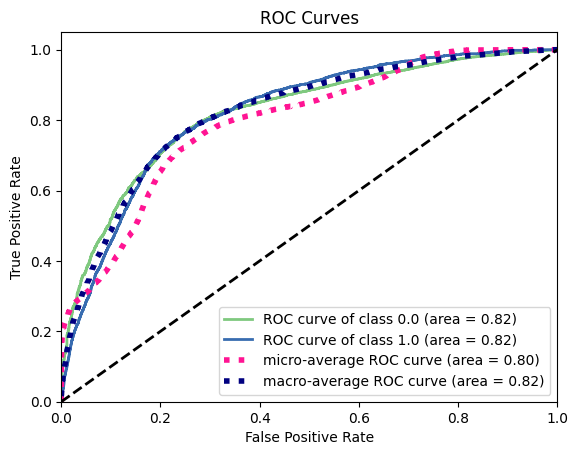

In [42]:
## not much (maybe a little) better 


models = {
    BalancedRandomForestClassifier: {
       # "n_estimators": [],
        "criterion": ['gini', 'entropy'],
        "max_depth": list(range(2, 12)),
        "min_samples_split": list(range(2, 25, 2)),
        "min_samples_leaf": list((range(4, 25, 3))),
        "sampling_strategy": [i*0.1 for i in range(4, 10, 1)],
        "class_weight": ['balanced', 'balanced_subsample']
    }
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
results = {}
for model, params in models.items():
    #print(f"Running model search number {i} out of {length}")
    #i += 1
    #gs = GridSearchCV(estimator=model(), param_grid=params, scoring='roc_auc', refit='roc_auc', cv=2, verbose=1, n_jobs=-1)
    gs = RandomizedSearchCV(estimator=model(), param_distributions=params, scoring='roc_auc', refit='roc_auc', n_iter=20, cv=2, verbose=1, n_jobs=-1)
    gs.fit(X_train, y_train)
    tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel()
    results[f"{str(gs.best_estimator_).split('(')[0]}"] = {'params': f'{gs.best_params_}', 'refit': f'{gs.best_score_}', 'roc_auc_test': f"{roc_auc_score(y_test, gs.predict_proba(X_test)[:, 1])}", 'tn': f'{tn}', 'fp': f'{fp}', 'fn': f'{fn}', 'tp': f'{tp}'}


for key, value in results.items():
    print(key, ' - ', value)

# plot ROC curve
import scikitplot as skplt
import matplotlib.pyplot as plt
# 
# 
y_true = y_test # ground truth labels
y_probas = gs.predict_proba(X_test)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc(y_true, y_probas, cmap='Accent')
# plt.style.use("seaborn-dark")
# plt.set_cmap()
plt.show()

Text(0.5, 1.0, 'Confusion matrix')

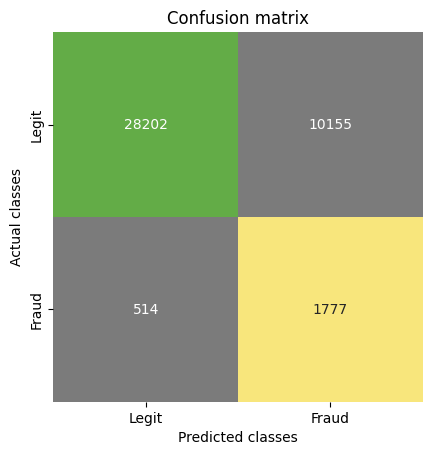

In [43]:
colors = ['#7b7b7b']*1 + ['#f8e67c']*15 + ['#7b7b7b']*30 + ['#63ac47']*4
sns.heatmap(confusion_matrix(y_test, gs.predict(X_test)), square=True, annot=True, fmt='d', cbar=False, cmap=colors)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.xticks([0.5, 1.5], ['Legit', 'Fraud'])
plt.yticks([0.5, 1.5], ['Legit', 'Fraud'])
plt.title('Confusion matrix')

In [44]:
y_pred = gs.predict(X_test)
x_test_numeric_columns = X_test[['mean_total_consommation', 'range_total_consommation', 'date_interval','std_total_consommation', 'count_mismatch_per_invoice']]
x_test_labeled = pd.concat([x_test_numeric_columns, y_true], axis=1)
x_test_labeled = pd.concat([x_test_labeled, pd.Series(y_pred, index=x_test_labeled.index, name='predicted')], axis=1)

In [45]:
def conf_matrix(li: pd.Series):
    target, pred = li.iloc[0], li.iloc[1]
    if target == 1 == pred:
        return 'tp'
    elif target == 0 == pred:
        return 'tn'
    elif target == 1 != pred:
        return 'fn'
    elif target == 0 != pred:
        return 'fp'

x_test_labeled['confusion_matrix'] = x_test_labeled[['target', 'predicted']].apply(conf_matrix, axis=1)

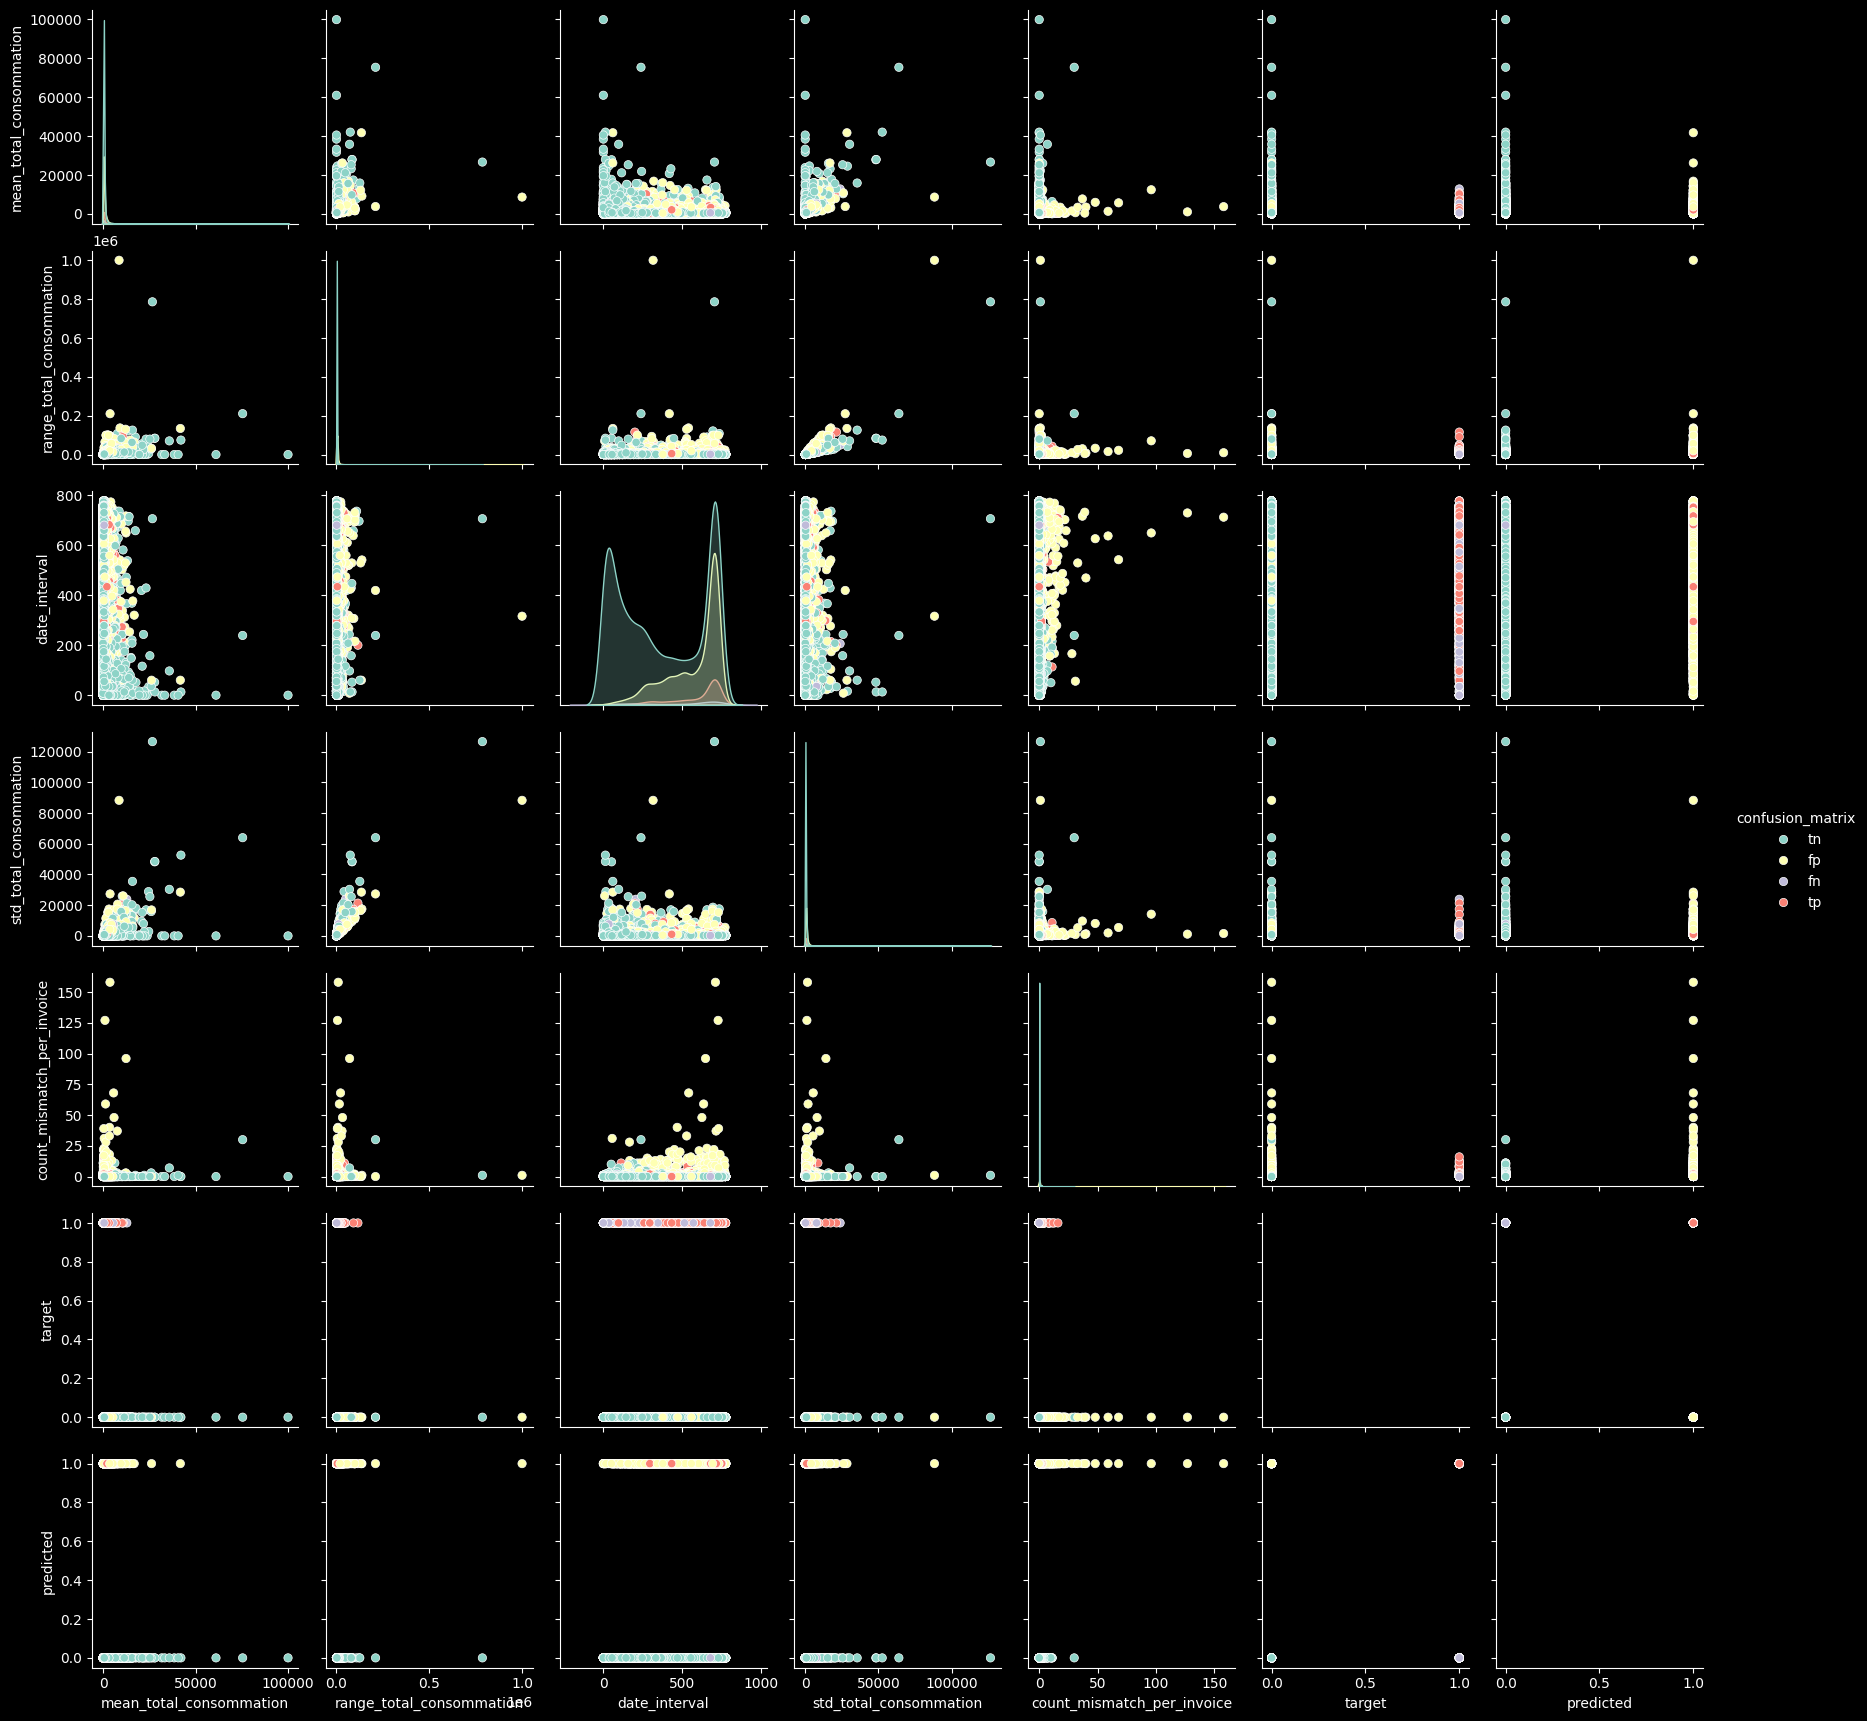

In [51]:
sns.pairplot(x_test_labeled, hue='confusion_matrix')

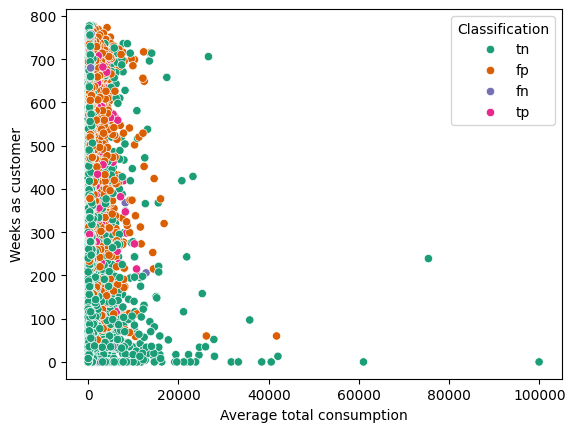

In [47]:
fig = sns.scatterplot(x_test_labeled, x='mean_total_consommation', y='date_interval', hue='confusion_matrix', palette='Dark2')
fig.set(xlabel='Average total consumption', ylabel='Weeks as customer')
fig.legend(title='Classification')
plt.style.use('dark_background')
plt.show()

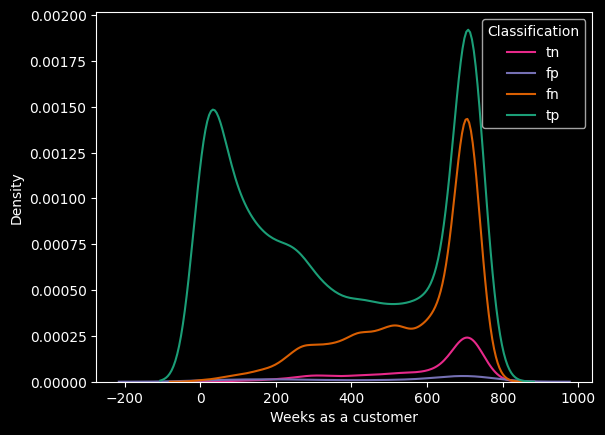

In [50]:
fig = sns.kdeplot(x_test_labeled, x='date_interval', hue='confusion_matrix', palette='Dark2')
fig.set(xlabel='Weeks as a customer', ylabel='Density')
fig.legend(['tn', 'fp', 'fn', 'tp'], title='Classification')
plt.style.use('dark_background')
# plt.figure(figsize=(4, 10))
plt.show()

In [45]:
## code to predict test data
clients_test = pd.read_csv('data/test/client_test.csv', low_memory=False, parse_dates=True)
invoices_test = pd.read_csv('data/test/invoice_test.csv', low_memory=False, parse_dates=True)

invoices_test['total_consommation'] = invoices_test.eval("consommation_level_1 + consommation_level_2 + consommation_level_3 + consommation_level_4")

invoices_grouped_test = invoices_test.groupby('client_id').mean(numeric_only=True)
invoices_grouped_test.rename(mapper={'total_consommation': 'mean_total_consommation'}, axis=1, inplace=True)
invoices_grouped_test = invoices_grouped_test.reset_index()
agg_clients_test = pd.merge(left=clients_test, right=invoices_grouped_test[['client_id', 'mean_total_consommation']], how='left')

count_num_test = invoices_test.groupby('client_id').counter_number.nunique().to_frame('number_of_counter_numbers').reset_index()
agg_clients_test = pd.merge(left=agg_clients_test, right=count_num_test, on='client_id')
del count_num_test

counter_dict_test = {'A': 0, '0': 0, '1': 1, '5': 5, '4': 4, '3': 3, '2': 2, '769': 0, '618': 0, '269375': 0, '46': 0, '420': 0}
invoices_test.counter_statue = invoices_test.counter_statue.map(lambda x: counter_dict_test.get(x, x)).astype('int')

df_test = pd.merge(left=clients_test, right=invoices_test, on='client_id', how='left')
counter_statues_test = df_test.groupby('client_id').counter_statue.apply(stats.mode).apply(lambda x: x[0]).to_frame('mode_counter_statue').reset_index()
agg_clients_test = pd.merge(left=agg_clients_test, right=counter_statues_test, on='client_id')
del counter_statues_test

remarque_dict_test = {5: 6, 207: 6, 413: 6, 203: 6}
invoices_test.reading_remarque = invoices_test.reading_remarque.map(lambda x: remarque_dict_test.get(x, x))

reading_mode_test = invoices_test.groupby('client_id').reading_remarque.apply(stats.mode).apply(lambda x: x[0]).to_frame('mode_reading_remarque').reset_index()
agg_clients_test = pd.merge(left=agg_clients_test, right=reading_mode_test, on='client_id')
del reading_mode_test

min_max_test = invoices_test.groupby('client_id').total_consommation.aggregate(['min', 'max'])
rng_total_consommation_test = min_max_test.apply(lambda x: x.to_list()[1] - x.to_list()[0], axis=1).to_frame('range_total_consommation').reset_index()
agg_clients_test = pd.merge(left=agg_clients_test, right=rng_total_consommation_test, on='client_id')
del min_max_test

invoices_test['invoice_date'] = pd.to_datetime(invoices_test['invoice_date'])

minmax_date_test = invoices_test.groupby('client_id').invoice_date.aggregate(['min','max']).reset_index()
minmax_date_test['date_interval'] =((minmax_date_test['max'] - minmax_date_test['min']) / np.timedelta64(1, 'W')).astype('int')
agg_clients_test = pd.merge(left=agg_clients_test, right=minmax_date_test[['client_id', 'date_interval']], on='client_id')
del minmax_date_test

gaz_type_test = invoices_test.groupby('client_id').counter_type.aggregate(['max']).reset_index()
gaz_dict_test = {'ELEC': 0, 'GAZ':1}
gaz_type_test['has_gaz'] = gaz_type_test['max'].map(gaz_dict)
agg_clients_test = pd.merge(left=agg_clients_test, right=gaz_type_test.drop('max', axis=1), on='client_id')
del gaz_type_test

std_consommation_test = invoices_test.groupby('client_id').total_consommation.std().reset_index()
std_consommation_test.rename(mapper={'total_consommation': 'std_total_consommation'}, axis=1, inplace=True)
agg_clients_test = pd.merge(left=agg_clients_test, right=std_consommation_test, on='client_id')
del std_consommation_test

invoices_test['diff_index'] = invoices_test['new_index'] - invoices_test['old_index']
invoices_test['count_mismatch_per_invoice'] = invoices_test['total_consommation'] != invoices_test['diff_index']
count_mismatch_test = invoices_test.groupby('client_id')['count_mismatch_per_invoice'].sum().sort_values(ascending=False).reset_index()
agg_clients_test = pd.merge(left=agg_clients_test, right=count_mismatch_test, on='client_id')
del count_mismatch_test

invoices_test['diff_index'] = invoices_test['new_index'] - invoices_test['old_index']
invoices_test['con_ind_mismatch'] = invoices_test['total_consommation'] != invoices_test['diff_index']
count_mismatch_test = invoices_test.groupby('client_id')[['diff_index', 'total_consommation']].sum().sort_values('diff_index', ascending=False).reset_index()
count_mismatch_test['count_mismatch_energy'] = count_mismatch_test['total_consommation'] - count_mismatch_test['diff_index']
count_mismatch_test['count_mismatch_pooled'] = count_mismatch_test['count_mismatch_energy'] != 0 
agg_clients_test = pd.merge(left=agg_clients_test, right=count_mismatch_test[['client_id', 'count_mismatch_pooled']], on='client_id')
del count_mismatch_test

X2 = agg_clients_test.drop(['client_id', 'creation_date'], axis=1)
X2.std_total_consommation = X2.std_total_consommation.fillna(0)

for col in X2.columns:
    if X2[col].nunique() < 30:
        dummie = pd.get_dummies(X2[col], drop_first=True, prefix=col)
        
        X2.drop(columns=col, inplace=True)
        X2 = X2.join(dummie, how='left')


results = pd.concat([agg_clients_test.client_id, pd.Series(gs.predict_proba(X2)[:, 1]).to_frame('target')], axis=1).set_index('client_id')
results.to_csv('results_4.csv')


In [ ]:
'''models = {
    KNeighborsClassifier: {
        "n_neighbors" : list(range(1, 31)),
        "weights" : ["uniform", "distance"],
        "p" : [1, 2, 3],
        "algorithm": ["ball_tree", "kd_tree", "brute"]
    },
    DecisionTreeClassifier: {
        "criterion": ['gini', 'entropy', 'log_loss'],
        "splitter": ['best', 'random'],
        "max_depth": list(range(2, 12)),
        "min_samples_leaf": list(range(1, 25, 2)),
        "max_leaf_nodes": list((range(4, 25, 3)))
    },
    RandomForestClassifier: {
        "n_estimators": [10, 50, 100],
        "criterion": ['gini', 'entropy', 'log_loss'],
        "max_depth": list(range(2, 7)),
        "min_samples_leaf": list(range(1, 25, 2)),
        "max_leaf_nodes": list((range(4, 22, 3)))
    },
    LogisticRegression: {
        "tol": [10**i for i in range(1, -7, -1)],
        "C": [10**i for i in range(-4, 8, 1)],
        "max_iter": [1000, 10000, 100000],
        "l1_ratio": [i/10 for i in range(1, 9, 1)],
        "penalty": ['l1', 'l2', 'elasticnet'],
        "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    },
    SGDClassifier: {
        "tol": [10**i for i in range(1, -7, -1)],
        "max_iter": [1000, 10000, 100000]
    },
    ExtraTreesClassifier: {
        "criterion": ['gini', 'entropy', 'log_loss'],
        "max_depth": list(range(2, 12)),
        "min_samples_split": list(range(2, 25, 2)),
        "min_samples_leaf": list((range(4, 25, 3)))
    }
}'''

models = {
    BalancedRandomForestClassifier: {
       # "n_estimators": [],
        "criterion": ['gini', 'entropy'],
        "max_depth": list(range(2, 12)),
        "min_samples_split": list(range(2, 25, 2)),
        "min_samples_leaf": list((range(4, 25, 3))),
        "sampling_strategy": [0.6, 0.8, 1],
        "class_weight": ['balanced', 'balanced_subsample']
    }
}

# scalers = [MinMaxScaler, StandardScaler, '']
scalers = [MinMaxScaler]
samplers = [RandomUnderSampler, SMOTE]
sampling_strategies = [i*0.1 for i in range(1, 9, 2)]
length = len(models.keys()) * len(scalers) * len(samplers) * len(sampling_strategies)
i = 1
results = {}
confusions = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


for sampling_strategy in sampling_strategies:
    
    for sampler_ in samplers:
        sampler = sampler_(random_state=0, sampling_strategy=sampling_strategy)
        X_res, y_res = sampler.fit_resample(X_train, y_train)

        for scaler_ in scalers:
            if scaler_:
                scaler = scaler_()
                X_train_scaled = scaler.fit_transform(X_res)
                X_test_scaled = scaler.transform(X_test)
            else:
                X_test_scaled = X_test

            for model, params in models.items():
                print(f"Running model search number {i} out of {length}")
                i += 1
                # gs = GridSearchCV(estimator=model(), param_grid=params, scoring=['f1', 'accuracy', 'recall'], refit='f1', cv=5, verbose=1, n_jobs=-1)
                gs = RandomizedSearchCV(estimator=model(), param_distributions=params, scoring='roc_auc', refit='roc_auc', n_iter=15, cv=2, verbose=1, n_jobs=-1)
                gs.fit(X_train_scaled, y_res)
                tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test_scaled)).ravel()
                results[f"{str(gs.best_estimator_).split('(')[0]} - {scaler_} - {sampler_} - {sampling_strategy}"] = {'params': f'{gs.best_params_}', 'refit': f'{gs.best_score_}', 'roc_auc_test': f"{roc_auc_score(y_test, gs.predict_proba(X_test_scaled)[:, 1])}", 'tn': f'{tn}', 'fp': f'{fp}', 'fn': f'{fn}', 'tp': f'{tp}'}


for key, value in results.items():
    print(key, ' - ', value)

Running model search number 1 out of 8
Fitting 2 folds for each of 15 candidates, totalling 30 fits


/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This chang

Running model search number 2 out of 8
Fitting 2 folds for each of 15 candidates, totalling 30 fits


/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This chang

Running model search number 3 out of 8
Fitting 2 folds for each of 15 candidates, totalling 30 fits


/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This chang

Running model search number 4 out of 8
Fitting 2 folds for each of 15 candidates, totalling 30 fits


/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This chang

Running model search number 5 out of 8
Fitting 2 folds for each of 15 candidates, totalling 30 fits


/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This chang

Running model search number 6 out of 8
Fitting 2 folds for each of 15 candidates, totalling 30 fits


/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This chang

Running model search number 7 out of 8
Fitting 2 folds for each of 15 candidates, totalling 30 fits


/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This chang

Running model search number 8 out of 8
Fitting 2 folds for each of 15 candidates, totalling 30 fits


/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vadymkhvoinytskyi/NeueFische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This chang

BalancedRandomForestClassifier - <class 'sklearn.preprocessing._data.MinMaxScaler'> - <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> - 0.1  -  {'params': "{'sampling_strategy': 1, 'min_samples_split': 22, 'min_samples_leaf': 4, 'max_depth': 11, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}", 'refit': '0.8069524171408047', 'roc_auc_test': '0.8176007372761995', 'tn': '27828', 'fp': '10529', 'fn': '502', 'tp': '1789'}
BalancedRandomForestClassifier - <class 'sklearn.preprocessing._data.MinMaxScaler'> - <class 'imblearn.over_sampling._smote.base.SMOTE'> - 0.1  -  {'params': "{'sampling_strategy': 0.6, 'min_samples_split': 8, 'min_samples_leaf': 16, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}", 'refit': '0.8250639855204589', 'roc_auc_test': '0.8171352967395936', 'tn': '30000', 'fp': '8357', 'fn': '611', 'tp': '1680'}
BalancedRandomForestClassifier - <class 'sklearn.preprocessing._data.MinMaxScal

In [ ]:
# sns.heatmap(confusion_matrix(y_test, gs.predict(X_test_scaled)), square=True, annot=True, fmt='d', cbar=False)

In [ ]:
# sns.heatmap(confusion_matrix(y, gs.predict(X)), square=True, annot=True, fmt='d', cbar=False)

In [ ]:
# invoices.groupby('client_id').months_number.nunique().sort_values(ascending=False)

In [ ]:
# count_num = invoices.groupby('client_id').counter_number.nunique().sort_values(ascending=False).reset_index()

# merged = pd.merge(left=count_num, right=clients, on='client_id')
# merged.corr(numeric_only=True)

In [ ]:
# px.imshow(clients.corr(numeric_only=True), text_auto=True)

In [ ]:
# px.imshow(invoices.corr(numeric_only=True), text_auto=True, height=800, width=800)

In [ ]:
# df = pd.merge(left=invoices, right=clients, on='client_id', how='left')

In [ ]:
# df['counter_type_int'] = df.counter_type.map({'GAZ': 0, 'ELEC': 1})

In [ ]:
# df.sample()

In [ ]:
# px.imshow(df.corr(numeric_only=True), text_auto=True, width=1000, height=1000, color_continuous_scale='RdBu')

In [ ]:
# grouped = df.groupby(['target', 'client_id']).consommation_level_1.std().reset_index().groupby('target').consommation_level_1.mean()

# px.imshow(grouped.corr(numeric_only=True), text_auto=True, width=1000, height=1000)
# grouped


In [ ]:
# df['date'] = pd.to_datetime(df.invoice_date)